## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
import pandas as pd
import numpy as np
import sys, os, time, datetime
import matplotlib.pyplot as plt


sys.path.append('Libraries')
import signal_processing as spl 
spl = reload(spl)

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
import sys

from collections import Counter

from scipy.cluster.vq import kmeans2,vq, whiten
from sklearn.cluster import KMeans
from hmmlearn.hmm import MultinomialHMM
from python_speech_features import mfcc

## Processing 

In [3]:
rate = 48000
# MAX_COLS = #-1


In [4]:
char_inps = pd.read_csv("LABELED_CHARACTER_INPUTS.csv", index_col=0)
char_inps['char'] = char_inps['char'].fillna(' ').replace('#SPACE', ' ')
char_inps['peak_diff'] =char_inps['peak_diff'].fillna(0)
char_inps.tail(10)

,index,peak time,signal,start time,end time,char,is_space,peak_diff,0,1,...,16791,16792,16793,16794,16795,16796,16797,16798,16799,16800
1042,1086,596.346667,12875.447266,596.311667,596.661667,b,0,0.270667,18.0,20.0,...,98.0,98.0,-60.0,-27.0,88.0,85.0,46.0,-21.0,-80.0,NaN
1043,1087,596.617333,22127.296875,596.582333,596.932333,b,0,0.149333,17.0,13.0,...,9.0,7.0,6.0,10.0,11.0,10.0,10.0,11.0,9.0,NaN
1044,1088,596.766667,2168.157959,596.731667,597.081667,i,0,0.354667,-5.0,4.0,...,-14.0,-16.0,-17.0,-13.0,-13.0,-21.0,-21.0,-14.0,-14.0,-19.0
1045,1089,597.121333,1214.426758,597.086333,597.436333,t,0,0.294000,26.0,26.0,...,48.0,243.0,253.0,147.0,56.0,-3.0,99.0,157.0,53.0,NaN
1046,1090,597.415333,25453.357422,597.380333,597.730333,,1,1.591333,10.0,6.0,...,-15.0,-15.0,-17.0,-25.0,-28.0,-21.0,-17.0,-21.0,-24.0,NaN
1047,1091,599.006667,6431.091797,598.971667,599.321667,h,0,0.247333,-3.0,-1.0,...,13.0,3.0,-6.0,17.0,10.0,-15.0,2.0,24.0,23.0,28.0
1048,1092,599.254000,3091.520508,599.219000,599.569000,o,0,0.462000,13.0,11.0,...,50.0,41.0,34.0,32.0,28.0,21.0,16.0,13.0,10.0,8.0
1049,1093,599.716000,913.455261,599.681000,600.031000,l,0,0.270667,2.0,4.0,...,40.0,-36.0,-24.0,100.0,-11.0,-66.0,54.0,46.0,41.0,33.0
1050,1094,599.986667,17315.521484,599.951667,600.301667,e,0,0.200667,-13.0,-19.0,...,-17.0,-140.0,-119.0,0.0,59.0,63.0,87.0,89.0,61.0,-7.0
1051,1095,600.187333,5176.197266,600.152333,600.502333,,0,0.000000,-18.0,-13.0,...,-12.0,-11.0,-7.0,-4.0,1.0,8.0,5.0,-1.0,2.0,6.0


12
Visualizing:  


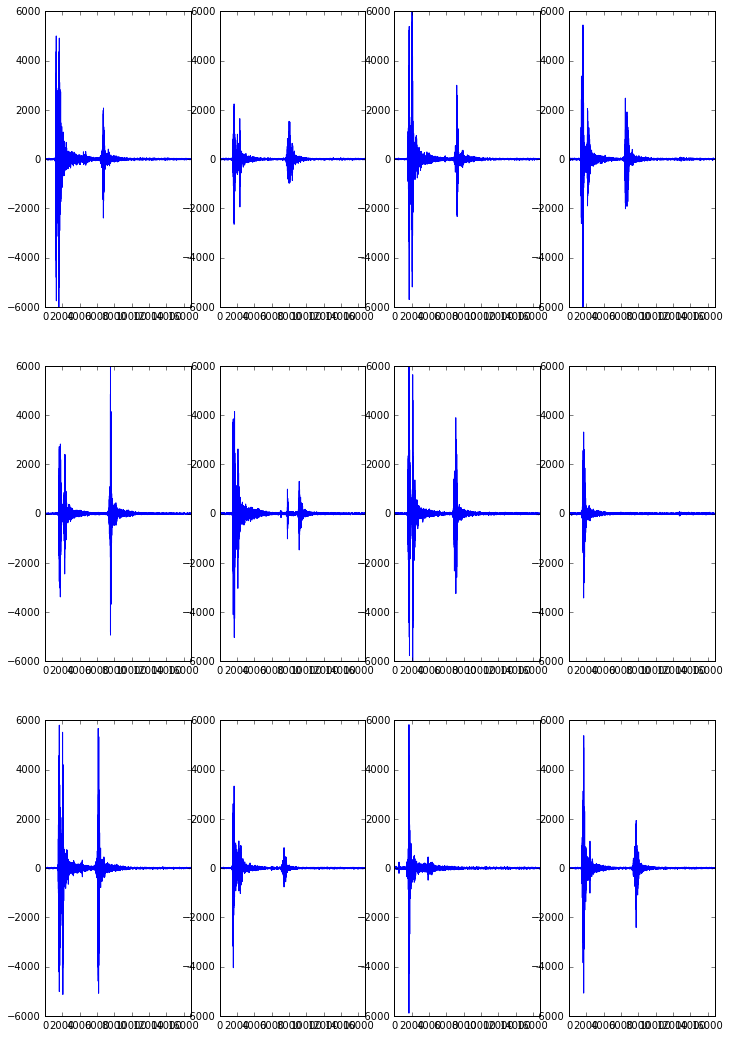

In [5]:
def view_char(df, input_char, xlim = 6000, limit = 10):
    sub_df = df[df['char'] == input_char]
    n = np.min([sub_df.shape[0], limit])
    print n
    lim = list(char_inps.columns).index('0')
    if n < 1:
        print 'No "%s" found' % input_char
        return
    print 'Visualizing: %s' % input_char
    # Plot histogram of coefficients, and report their confidence intervals 
    fig, axes = plt.subplots((n-1)/4+1, 4, figsize=(12, n*3/2))

    # Repeat for each coefficient
    for idx in range(n):
        if ((n+1) / 4 ) > 1:
            axe = axes[idx / 4][idx % 4]
        else:
            axe = axes[idx]

        # Plot histogram of coefficient values
        sub_df.iloc[idx].ix[lim:].plot(ax = axe)
        axe.set_ylim([-xlim, xlim])

view_char(char_inps, ' ', limit = 12)

In [6]:
# view_char(char_inps, 'a', limit = 12)

In [7]:
# view_char(char_inps, 'b', limit = 12)

In [8]:
# view_char(char_inps, 'm', limit = 12)

12
Visualizing: e


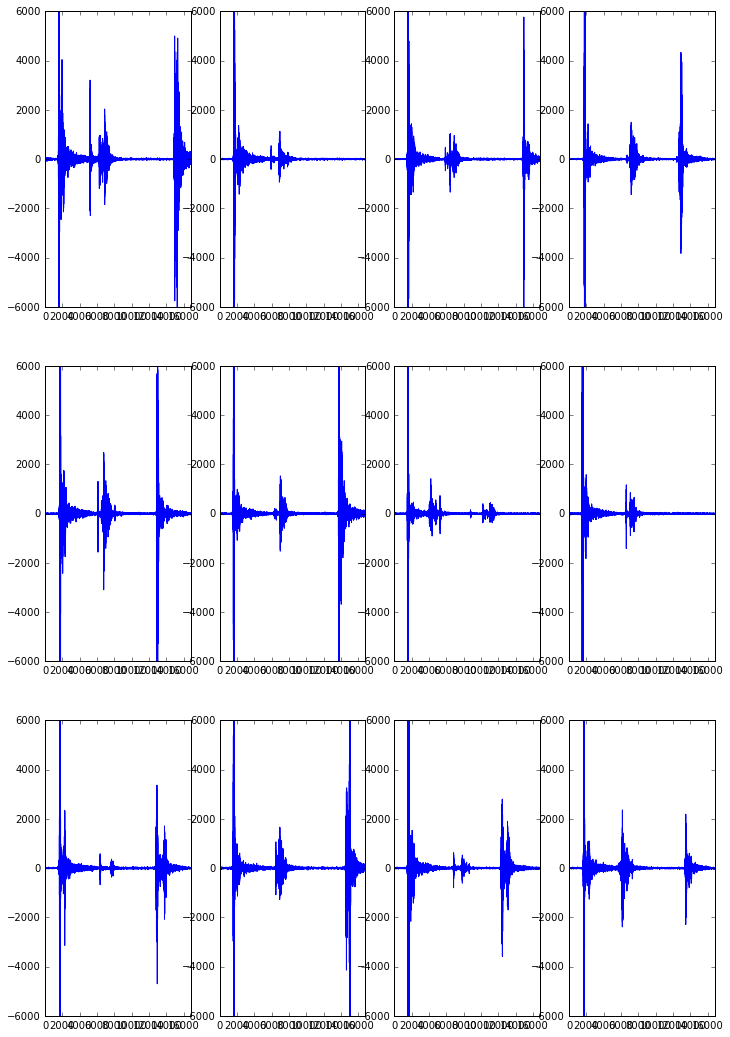

In [9]:
view_char(char_inps, 'e', limit = 12)

In [10]:
targ_s = "".join([" " if c == '#SPACE' else c for c in list(char_inps['char'].values)])
targ_s

'alice was beginning to get very tired of sitting by her sister on the bank and having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversations so she was considering in her own mind a well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies when suddenly a white rabbit with pink eyes ran close by her there was nothing so very emarkable in that nor did alice think it so very much oh dear i shall be late it occurred to her afterwards she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually toook a watch out of its packet and looked at it and then hurried on alice started to her feet and in another moment down went alice after it never once considering burning how in the 

In [11]:
mike_char_data = char_inps[char_inps.columns[list(char_inps.columns).index('0'):]].values
mike_char_data.shape
mike_char_data

(1052, 16801)

array([[   0.,   -2.,   -3., ...,   16.,   39.,   30.],
       [ -21.,  -18.,  -15., ..., -841., -547.,   nan],
       [  -7.,  -11.,   -9., ...,   -2.,  -12.,   -9.],
       ..., 
       [   2.,    4.,   11., ...,   46.,   41.,   33.],
       [ -13.,  -19.,  -23., ...,   89.,   61.,   -7.],
       [ -18.,  -13.,  -12., ...,   -1.,    2.,    6.]])

In [12]:
mike_keypress_data = np.split(mike_char_data, mike_char_data.shape[0], axis=0)
mike_keypress_data = [np.squeeze(l) for l in mike_keypress_data]

mike_keypress_data

[array([  0.,  -2.,  -3., ...,  16.,  39.,  30.]),
 array([ -21.,  -18.,  -15., ..., -841., -547.,   nan]),
 array([ -7., -11.,  -9., ...,  -2., -12.,  -9.]),
 array([-19., -18., -16., ..., -23., -36., -25.]),
 array([  14.,  -19.,  -23., ..., -158., -145., -107.]),
 array([ 12.,   7.,  -4., ...,   9.,   8.,   8.]),
 array([   7.,    8.,    5., ...,  161.,  604.,  500.]),
 array([  -4.,   -5.,   -3., ..., -126.,   33.,   45.]),
 array([ 14.,  10.,   7., ...,  13.,  16.,  16.]),
 array([ 4.,  0., -1., ..., -2.,  0., -2.]),
 array([ 13.,  11.,  14., ...,   4.,   2.,  -1.]),
 array([-26., -28., -32., ...,  -2.,   5.,   6.]),
 array([ -6.,  -8., -10., ...,   2.,  40.,  13.]),
 array([ 43.,  36.,  28., ...,  15.,  16.,  10.]),
 array([   0.,    0.,   -2., ..., -287.,  -67.,   nan]),
 array([  -8.,   -8.,   -6., ..., -407., -571., -482.]),
 array([  -8.,   -9.,   -7., ..., -455., -624., -477.]),
 array([ 15.,   6.,   2., ...,  23.,  23.,  nan]),
 array([ -8.,   1.,   8., ...,   9.,   6.,  11

In [13]:
data = spl.extract_cepstrum(mike_keypress_data, rate, mfcc_start=0, mfcc_end=19)
data

array([[  7.51026457, -18.26804536, -14.85626542, ...,  10.29106295,
        -15.70700081,  -2.96492725],
       [  8.62020855, -19.48312456, -16.9417953 , ...,  -8.72570467,
         -3.80184674, -13.17194663],
       [  8.66255884, -11.77956273, -21.29423022, ...,  -4.0004789 ,
         13.15676875,  -3.80452123],
       ..., 
       [  8.48060259, -13.75834558, -21.87453233, ..., -13.28825702,
          4.80196672,  -5.53531035],
       [  7.94469582, -17.56561913, -26.12622072, ...,   2.40421474,
         -3.64549781,  -1.05341433],
       [  8.55831564, -16.80500498, -12.65680316, ...,  -6.54179716,
        -19.19389672,  -7.770941  ]])

In [14]:
cepstrum_df = pd.DataFrame(data)
cepstrum_df['char'] = char_inps['char']
cepstrum_df = cepstrum_df.reindex(columns = [cepstrum_df.columns[-1]] + list(cepstrum_df.columns[:-1]))
cepstrum_df.head()

,char,0,1,2,3,4,5,6,7,8,...,294,295,296,297,298,299,300,301,302,303
0,a,7.510265,-18.268045,-14.856265,3.473099,-28.350535,-10.377419,-16.865954,10.942464,-14.298184,...,-18.558073,27.619609,-10.462164,17.331623,-44.647548,7.925898,-24.214322,10.291063,-15.707001,-2.964927
1,l,8.620209,-19.483125,-16.941795,-9.416150,-32.485123,-18.096579,-23.681093,1.677687,-23.470773,...,-10.991725,24.430472,-22.540166,21.515831,-20.033261,21.306528,1.265333,-8.725705,-3.801847,-13.171947
2,i,8.662559,-11.779563,-21.294230,-6.025305,-38.506534,-6.979232,-30.559670,3.472228,-22.042352,...,-27.942196,12.690096,-7.884997,6.424651,-14.302479,0.423132,9.714163,-4.000479,13.156769,-3.804521
3,c,8.316791,-11.337112,-13.734893,1.250301,-26.438948,-4.978659,-24.679192,2.589624,-19.789418,...,-41.086678,16.047761,-17.047476,10.380985,-29.345816,12.386576,-23.689263,-12.535017,-9.729814,-0.791819
4,e,11.847376,-32.616993,-12.516634,10.001307,-31.924242,3.392823,-29.665115,15.489533,-55.358497,...,-29.407541,5.192396,-38.933629,5.746049,-33.433767,5.799319,-25.191063,-5.724175,-7.841381,-14.730767


12
Visualizing:  


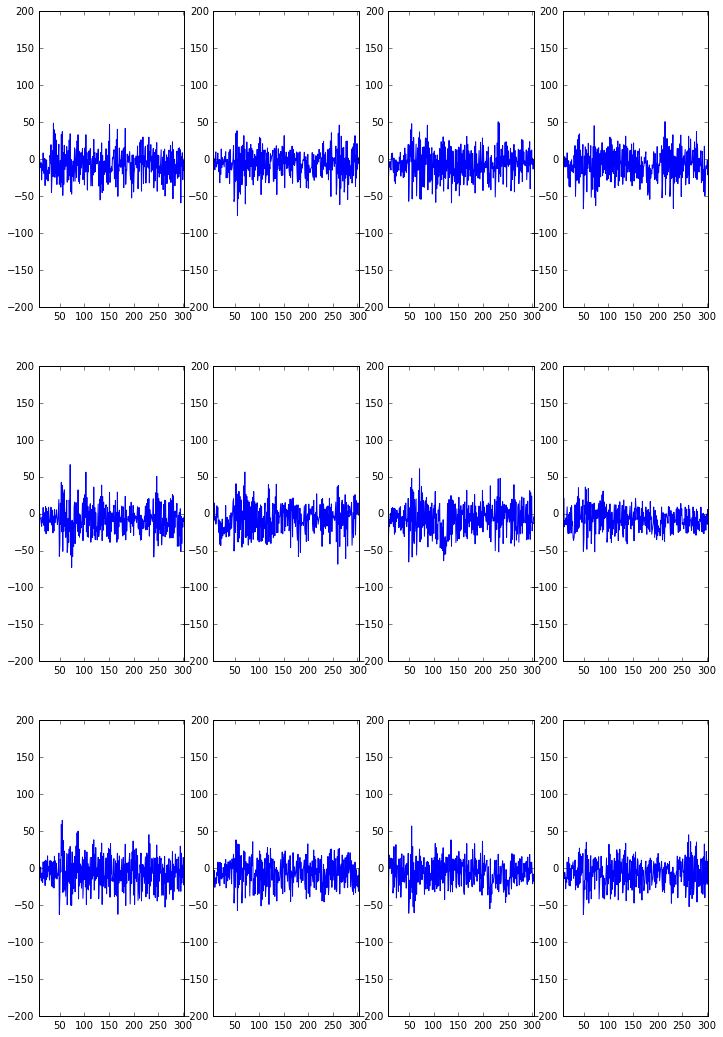

In [15]:
view_char(cepstrum_df, ' ', xlim = 200, limit = 12)

12
Visualizing: a


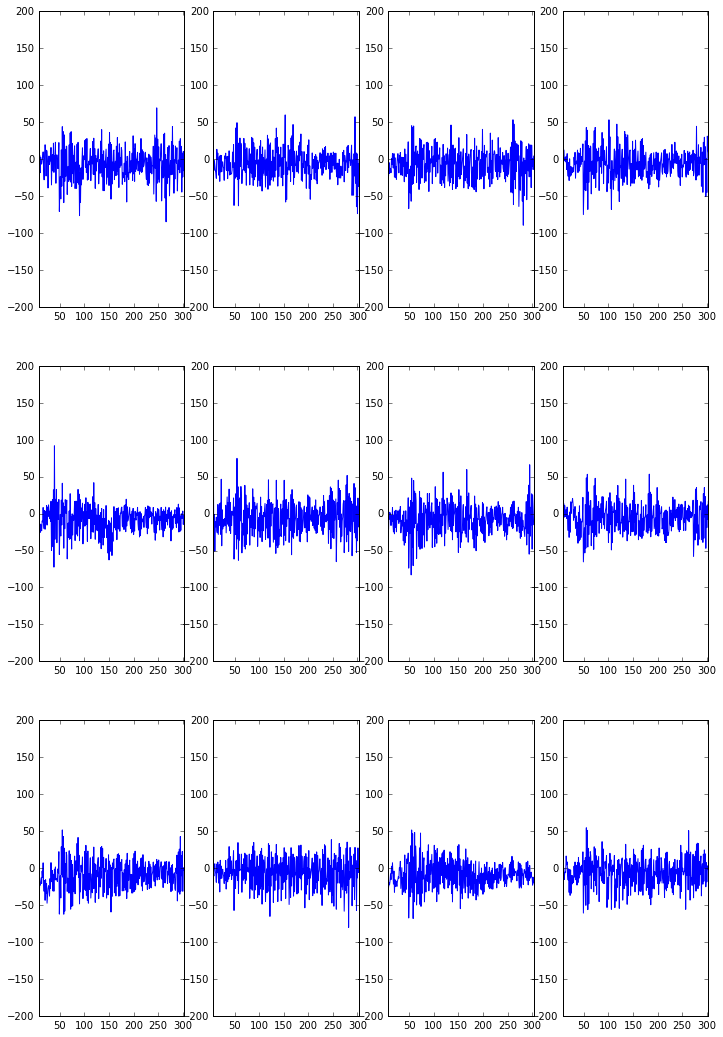

In [16]:
view_char(cepstrum_df, 'a', xlim = 200, limit = 12)

12
Visualizing: e


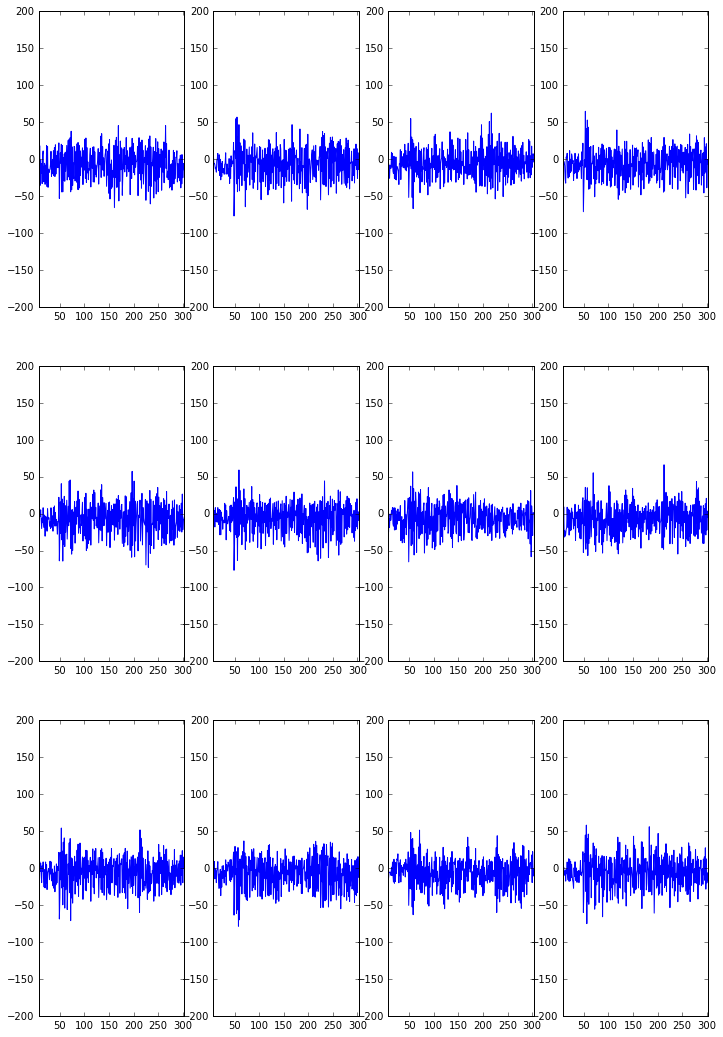

In [17]:
view_char(cepstrum_df, 'e', xlim = 200, limit = 12)

In [18]:
num_clusters = 50
def cluster(df, whiten_data=True, num_clusters=50, n_init = 30):
    kmeans = KMeans(n_clusters=num_clusters, n_init = n_init).fit(data)
    
    # Get labels from running clustering
    labels = kmeans.labels_.reshape(-1, 1)
    df['cluster'] = labels
    return df
cepstrum_df = cluster(cepstrum_df, num_clusters = num_clusters)
cepstrum_df.head()

,char,0,1,2,3,4,5,6,7,8,...,295,296,297,298,299,300,301,302,303,cluster
0,a,7.510265,-18.268045,-14.856265,3.473099,-28.350535,-10.377419,-16.865954,10.942464,-14.298184,...,27.619609,-10.462164,17.331623,-44.647548,7.925898,-24.214322,10.291063,-15.707001,-2.964927,38
1,l,8.620209,-19.483125,-16.941795,-9.416150,-32.485123,-18.096579,-23.681093,1.677687,-23.470773,...,24.430472,-22.540166,21.515831,-20.033261,21.306528,1.265333,-8.725705,-3.801847,-13.171947,32
2,i,8.662559,-11.779563,-21.294230,-6.025305,-38.506534,-6.979232,-30.559670,3.472228,-22.042352,...,12.690096,-7.884997,6.424651,-14.302479,0.423132,9.714163,-4.000479,13.156769,-3.804521,45
3,c,8.316791,-11.337112,-13.734893,1.250301,-26.438948,-4.978659,-24.679192,2.589624,-19.789418,...,16.047761,-17.047476,10.380985,-29.345816,12.386576,-23.689263,-12.535017,-9.729814,-0.791819,38
4,e,11.847376,-32.616993,-12.516634,10.001307,-31.924242,3.392823,-29.665115,15.489533,-55.358497,...,5.192396,-38.933629,5.746049,-33.433767,5.799319,-25.191063,-5.724175,-7.841381,-14.730767,8


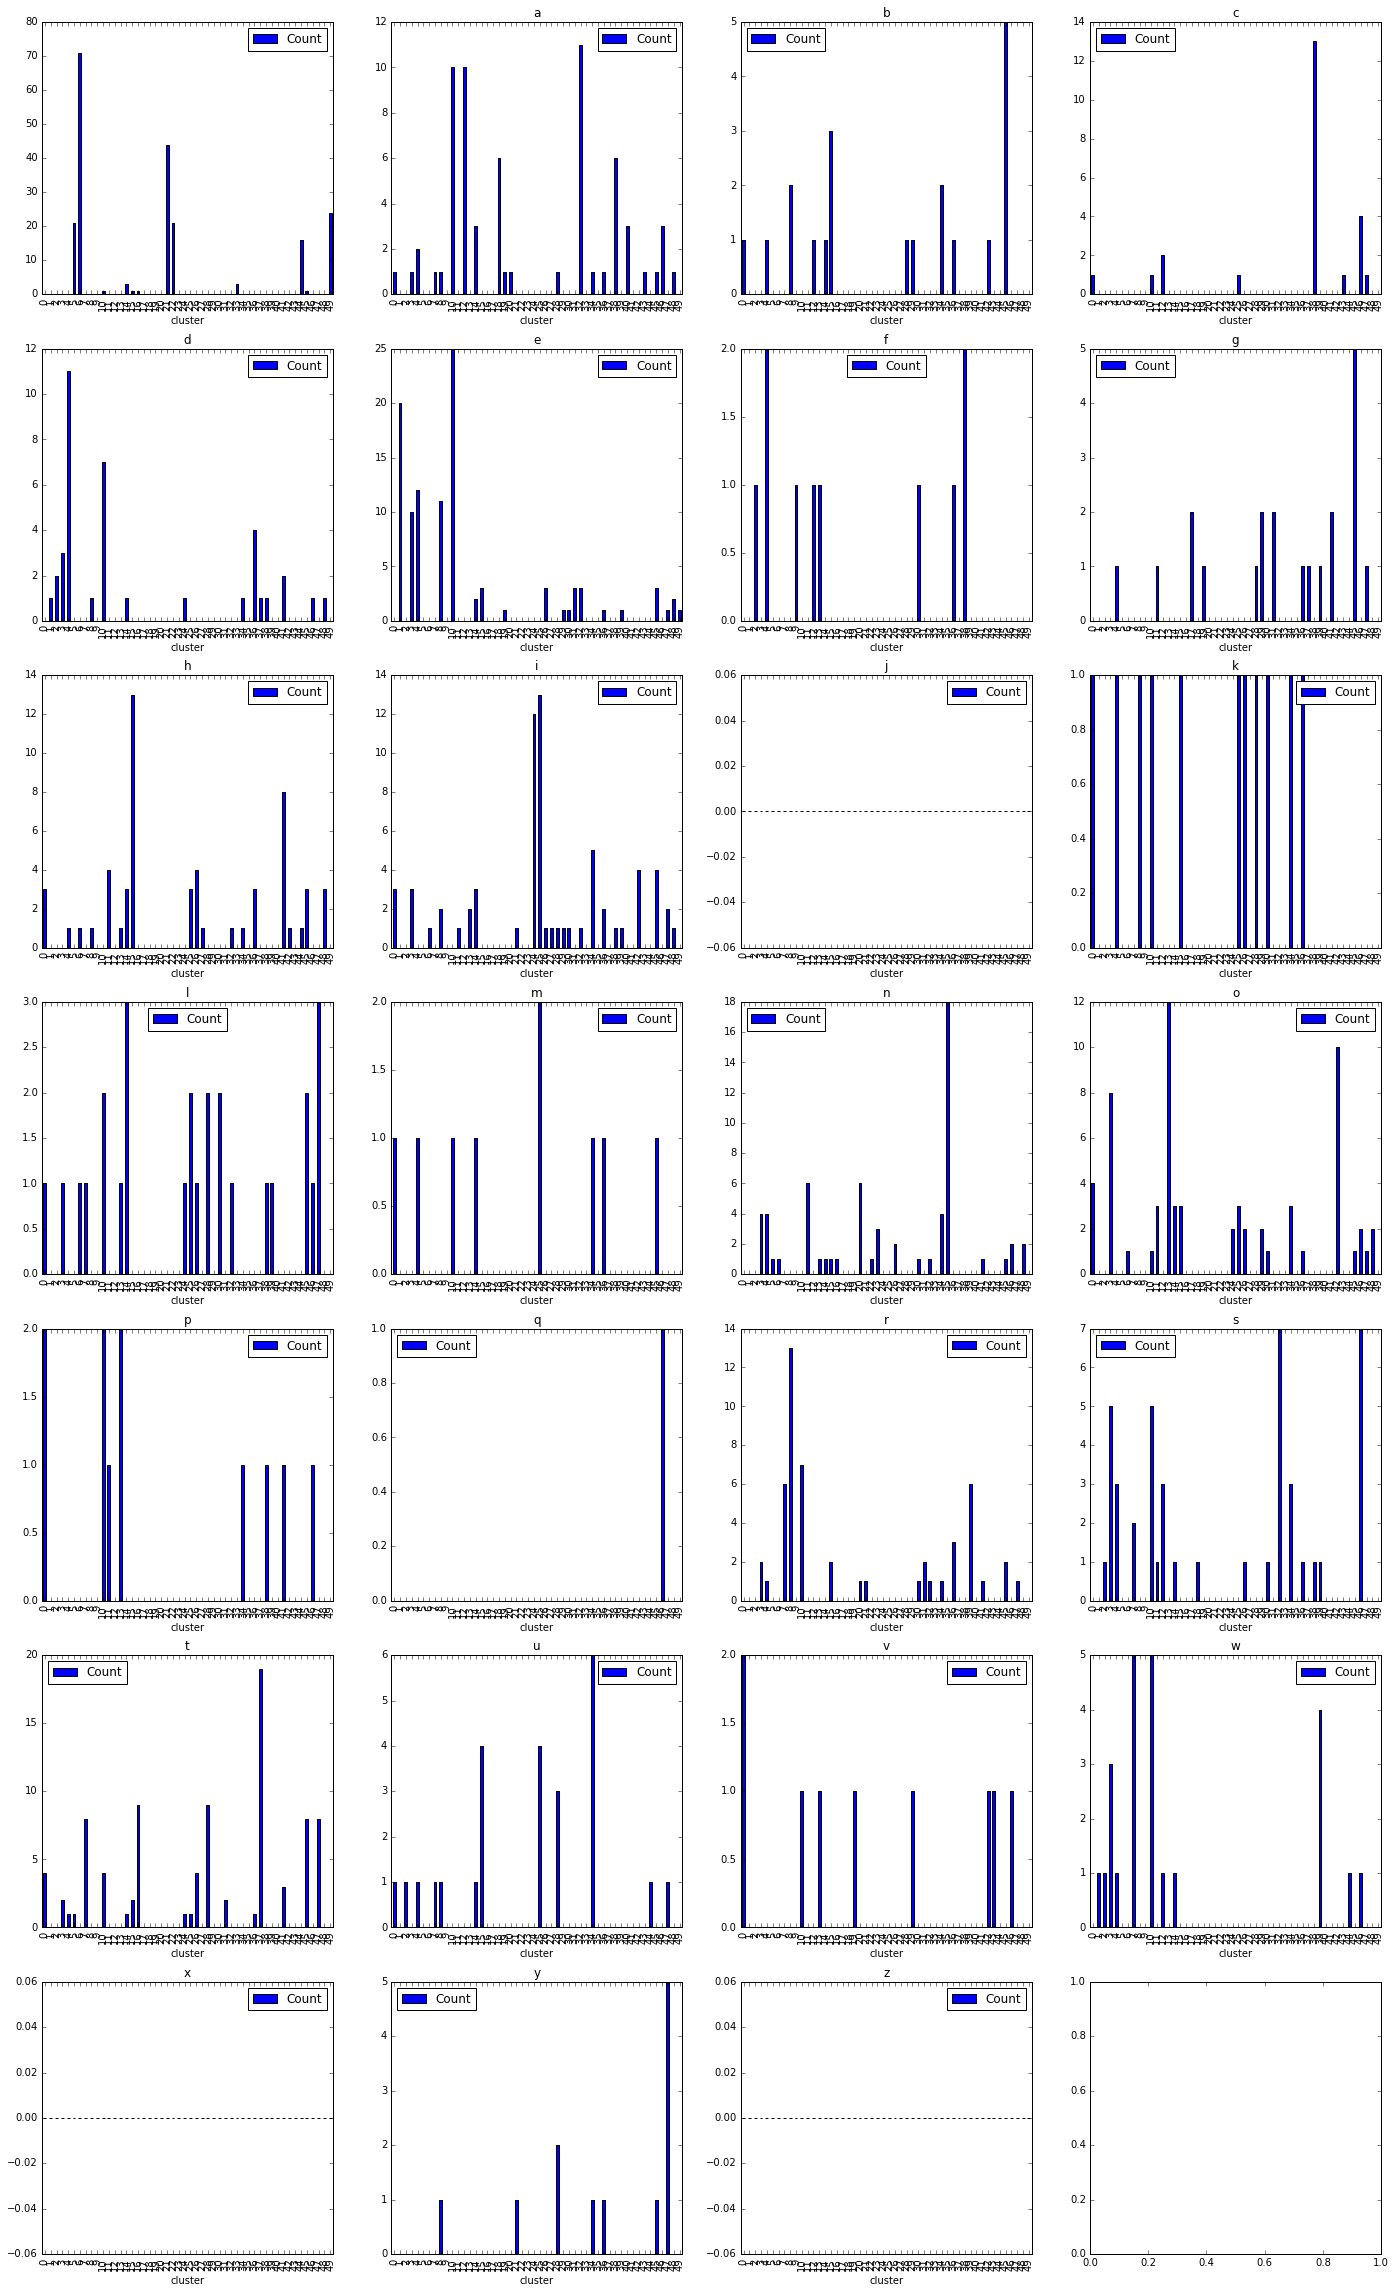

In [19]:
def to_hist(data, num_clusters, smooth_2 = 0):


    df = pd.DataFrame(data)
    df['Count'] = 1
    counts = df.groupby('cluster').count() 
    counts = counts.reindex(index = range(num_clusters)).fillna(0) + smooth_2
    return counts


def cluster_proportions(df, input_char, num_clusters = 50):
    if type(input_char) == list:
        n = len(input_char)
        fig, axes = plt.subplots((n-1)/4+1, 4, figsize=(24, n*3/2))

        # Repeat for each coefficient
        for idx, ch in enumerate(input_char):
            if ((n+1) / 4 ) > 1:
                axe = axes[idx / 4][idx % 4]
            else:
                axe = axes[idx]
            sub_df = df[df['char'] == ch]
            counts = to_hist(sub_df['cluster'], num_clusters)
            counts.plot(kind='bar', ax = axe)
            axe.set_title(ch)
    else:
        sub_df = df[df['char'] == input_char]
        sub_df['cluster'].hist(bins = bins)

cluster_proportions(cepstrum_df, [' '] + map(lambda x : chr(x + ord('a')),  range(26)), num_clusters = num_clusters)

In [20]:
def build_transmission(text, smooth = .01):
    unique_chars = np.unique(list(text))
    n_unique = len(unique_chars)
    id_to_char = dict(zip(range(n_unique), unique_chars))
    char_to_id = dict(zip(unique_chars, range(n_unique)))

    char_bigrams = dict(Counter([text[i:i+2] for i in range(len(text)-1)]))
    A = np.zeros((n_unique,n_unique)) + smooth
    for big in char_bigrams:
        x, y = map(lambda x : char_to_id[x], big)
        A[x,y] = char_bigrams[big]
    A_df = pd.DataFrame(A, index = unique_chars, columns = unique_chars)
    A_df = A_df.apply(lambda x : x / x.sum(), axis = 1)
    
    return A_df, n_unique, unique_chars, id_to_char, char_to_id
A_df, n_unique, unique_chars, id_to_char, char_to_id  =build_transmission(targ_s)
A_df

,,a,b,c,d,e,f,g,h,i,...,o,p,q,r,s,t,u,v,w,y
,0.000049,0.126195,0.058244,0.033976,0.033976,0.009707,0.014561,0.019415,0.072805,0.077659,...,0.087366,0.033976,0.004854,0.024268,0.082512,0.135903,0.009707,0.019415,0.092220,0.000049
a,0.075654,0.000151,0.060524,0.030262,0.060524,0.000151,0.030262,0.015131,0.000151,0.060524,...,0.000151,0.000151,0.000151,0.060524,0.105916,0.151309,0.000151,0.030262,0.000151,0.015131
b,0.000496,0.049603,0.148810,0.000496,0.000496,0.148810,0.000496,0.000496,0.000496,0.148810,...,0.099206,0.000496,0.000496,0.000496,0.000496,0.000496,0.198413,0.000496,0.000496,0.099206
c,0.000414,0.000414,0.000414,0.041391,0.000414,0.331126,0.000414,0.000414,0.124172,0.000414,...,0.206954,0.000414,0.000414,0.000414,0.000414,0.124172,0.041391,0.000414,0.000414,0.000414
d,0.602567,0.078596,0.000262,0.000262,0.026199,0.157192,0.000262,0.000262,0.000262,0.052397,...,0.052397,0.000262,0.000262,0.000262,0.026199,0.000262,0.000262,0.000262,0.000262,0.000262
e,0.374640,0.028818,0.000096,0.000096,0.076849,0.048031,0.000096,0.009606,0.000096,0.000096,...,0.000096,0.019212,0.000096,0.230548,0.038425,0.057637,0.000096,0.009606,0.000096,0.009606
f,0.490196,0.000980,0.000980,0.000980,0.000980,0.196078,0.000980,0.000980,0.000980,0.000980,...,0.098039,0.000980,0.000980,0.000980,0.000980,0.196078,0.000980,0.000980,0.000980,0.000980
g,0.613787,0.047214,0.000472,0.000472,0.000472,0.141643,0.000472,0.000472,0.094429,0.047214,...,0.047214,0.000472,0.000472,0.000472,0.000472,0.000472,0.000472,0.000472,0.000472,0.000472
h,0.089015,0.142425,0.000178,0.000178,0.000178,0.534093,0.000178,0.000178,0.000178,0.089015,...,0.089015,0.000178,0.000178,0.000178,0.000178,0.035606,0.017803,0.000178,0.000178,0.000178
i,0.014894,0.000149,0.000149,0.134048,0.059577,0.029789,0.000149,0.000149,0.000149,0.000149,...,0.029789,0.000149,0.000149,0.014894,0.089366,0.238308,0.000149,0.000149,0.000149,0.000149


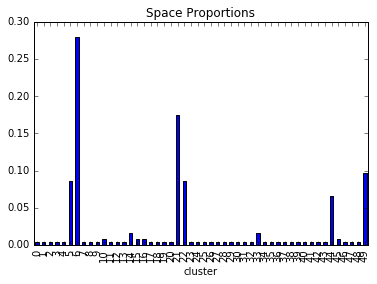

In [22]:
def get_space_props(cepstrum_df, smooth_space = 1):
    spaces = cepstrum_df[cepstrum_df['char'] == ' ']['cluster']
    space_props = to_hist(spaces, num_clusters, smooth_space)['Count']
    space_props /= space_props.sum()
    return space_props
space_props= get_space_props(cepstrum_df)
_  = space_props.plot(kind='bar', title = 'Space Proportions')

In [23]:
def build_eta(unique_chars, space_props, num_clusters):
    space_ind = list(unique_chars).index(' ')
    Eta = np.random.rand(len(unique_chars), num_clusters)
    Eta[space_ind,:] = space_props.values
    Eta/=Eta.sum(axis=1)[:,None]
    return Eta
Eta = build_eta(unique_chars, space_props, num_clusters)
Eta

array([[ 0.00389105,  0.00389105,  0.00389105, ...,  0.00389105,
         0.00389105,  0.09727626],
       [ 0.00194643,  0.00697535,  0.02840211, ...,  0.00523523,
         0.03954047,  0.00099215],
       [ 0.03418588,  0.03859706,  0.03909162, ...,  0.01206805,
         0.03571924,  0.00569448],
       ..., 
       [ 0.02153683,  0.03724275,  0.02281841, ...,  0.00700161,
         0.01633016,  0.02633223],
       [ 0.02711946,  0.02734368,  0.01882329, ...,  0.0080023 ,
         0.0057683 ,  0.00358878],
       [ 0.01026326,  0.03632661,  0.00442005, ...,  0.03969691,
         0.00480593,  0.00502789]])

In [53]:
def get_char_counts(text, unique_chars, smooth = 1):
    char_counts = pd.Series(dict(Counter(list(text)))).reindex(index = unique_chars)
    char_counts[' '] = 0
#     char_counts.ix[:] = 0
#     char_counts['a'] = 10000
    char_counts += smooth
    char_counts /= char_counts.sum()
    return char_counts
char_counts = get_char_counts(targ_s, unique_chars)
char_counts

     0.001151
a    0.077100
b    0.024166
c    0.028769
d    0.044879
e    0.120829
f    0.012658
g    0.025316
h    0.065593
i    0.078251
k    0.013809
l    0.032221
m    0.011507
n    0.072497
o    0.075949
p    0.013809
q    0.002301
r    0.059839
s    0.051784
t    0.102417
u    0.029919
v    0.011507
w    0.028769
y    0.014960
dtype: float64

In [54]:
def run_hmm_model(input_df, n_unique, char_counts, A_df, n_iter = 10000, tol=1e-5, verbose = True, params = 'e', init_params = ''):
    hmm = MultinomialHMM(n_components=n_unique, startprob_prior=char_counts.values, 
               transmat_prior=A_df.values, algorithm='viterbi', 
               random_state=None, n_iter=n_iter, tol=tol, 
               verbose=verbose, params=params, init_params=init_params)
    
    hmm.emissionprob_ = Eta

#     full_input = input_df[input_df.columns[list(cepstrum_df).index(0):]].values
    short_input = input_df['cluster'].values
    model_input = short_input
    
    if len(model_input.shape) == 1:
        model_input = model_input.reshape((len(model_input), 1))
        
    hmm = hmm.fit(model_input)

    return hmm.decode(model_input)    

In [55]:
def to_text(results, id_to_char):
    return ''.join(map(lambda x : id_to_char[x], results))

In [67]:
def run_hmm(input_df, text, num_clusters, t_smooth = 1):
    A_df, n_unique, unique_chars, id_to_char, char_to_id = build_transmission(text, t_smooth)
    space_props= get_space_props(input_df)
    Eta = build_eta(unique_chars, space_props, num_clusters)
    print A_df.ix['a', 'g']
    char_counts = get_char_counts(text, unique_chars)
    A_df = 0
    score, results = run_hmm_model(input_df, n_unique, char_counts, A_df)
    return to_text(results, id_to_char)

smooths = map(lambda x : np.exp(x), range(-10, 10))
for smooth in [0,1]:
    print smooth
    run_hmm(cepstrum_df, targ_s, num_clusters, t_smooth = smooth)

0
0.0151515151515


AttributeError: 'int' object has no attribute 'values'

In [57]:
targ_s

'alice was beginning to get very tired of sitting by her sister on the bank and having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversations so she was considering in her own mind a well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies when suddenly a white rabbit with pink eyes ran close by her there was nothing so very emarkable in that nor did alice think it so very much oh dear i shall be late it occurred to her afterwards she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually toook a watch out of its packet and looked at it and then hurried on alice started to her feet and in another moment down went alice after it never once considering burning how in the 